# Setting up Environment for google.colab

In [ ]:
![ -d sample_data ] && rm -rf sample_data

!echo '{"username":"garakhantalibov","key":"819f819ec679662985b5abea0c29d37b"}' > kaggle.json

In [ ]:
![ ! -d /root/.kaggle ] && mkdir /root/.kaggle && mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pip install kaggle==1.5.6 &> /dev/null | tqdm #

# !pip install timm
# !pip install efficientnet_pytorch &>/dev/null
# !pip install transformers &>/dev/null
# !pip install huggingface-hub &>/dev/null

0it [00:00, ?it/s]


# Importing Utils and Reading Data

In [ ]:
import torch

dev="cuda" if torch.cuda.is_available() else "cpu"
if dev=="cuda":
  print (f"Available gpu is :{torch.cuda.get_device_name (dev)}.")
else:
  print (f"GPU not available :{torch.cuda.get_device_name(dev)}.")

Available gpu is :Tesla P100-PCIE-16GB.


In [ ]:
!kaggle datasets download cdeotte/effnetb0
!unzip *.zip

effnetb0.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  effnetb0.zip
caution: filename not matched:  shopee-product-matching.zip


In [ ]:
#Download dataset
print('{:<30}'.format("Downloading dataset..."), end="")
! [ ! -f shopee-product-matching.zip ] && kaggle competitions download -c shopee-product-matching
print ("+[DONE]")
print ('{:<30}'.format("Unzipping dataset..."), end="")
! [ ! -d shopee-product-matching ] && unzip -q shopee-product-matching.zip
print ("+[DONE]")

Unzipping dataset...          replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
+[DONE]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from IPython.display import clear_output
from sklearn.metrics.pairwise import cosine_similarity
import sys

In [ ]:
# When submitting path will read test images

SUBMIT=False
csv="train.csv"
img_dir="./train_images/"
if SUBMIT:
  csv="input/shopee-product-matching/test.csv"
  img_dir="input/shopee-product-matching/test_images/"

In [ ]:
tmp = dataset.groupby('label_group').posting_id.agg('unique').to_dict()
dataset['target'] = dataset.label_group.map(tmp)

In [ ]:
dataset=pd.read_csv (csv)
dataset.head(5)

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


# Text Embedding

In [ ]:
dataset.title.values

array(['Paper Bag Victoria Secret',
       'Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE',
       'Maling TTS Canned Pork Luncheon Meat 397 gr', ...,
       'KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Metal Wired Headset',
       'Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , Sapi Lokal,  Jamur (Bkn Alsultan / Biocell)',
       'FLEX TAPE PELAPIS BOCOR / ISOLASI AJAIB / ANTI BOCOR'],
      dtype=object)

In [ ]:
text_model=TfidfVectorizer()
X=text_model.fit_transform(dataset.title.values)

In [ ]:
KNN=50
neighbors_model=NearestNeighbors(n_neighbors=KNN)
nbrs=neighbors_model.fit(X)
text_distances, text_indices=nbrs.kneighbors(X)

In [ ]:
text_distances[2]

array([0.        , 0.82217635, 1.25703821, 1.28080405, 1.28631348,
       1.28909208, 1.2975505 , 1.30973434, 1.31892068, 1.31929765,
       1.32237986, 1.32923212, 1.33190789, 1.33496716, 1.33546747,
       1.33673941, 1.33852232, 1.34003019, 1.34003019, 1.34072808,
       1.34082006, 1.34132191, 1.34153475, 1.34153959, 1.35082743,
       1.35292456, 1.35309501, 1.35578771, 1.35758929, 1.35758929,
       1.35758929, 1.36175874, 1.36408761, 1.36457184, 1.3646484 ,
       1.36493947, 1.36548974, 1.36548974, 1.36567794, 1.36724572,
       1.36788753, 1.36806297, 1.36806927, 1.36807765, 1.36827238,
       1.36827238, 1.36866281, 1.36878968, 1.36892309, 1.36901089])

In [ ]:
sim=cosine_similarity(X)

In [ ]:
np.argwhere(sim[0:2]>0.5).tolist()

[[0, 0],
 [0, 33161],
 [1, 1],
 [1, 194],
 [1, 469],
 [1, 4774],
 [1, 4878],
 [1, 10444],
 [1, 10647],
 [1, 18032],
 [1, 18683],
 [1, 19262],
 [1, 21790],
 [1, 23323],
 [1, 23593],
 [1, 25199]]

In [ ]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

In [ ]:
m=0
for i in idxs:
  for j in i:
    m+=sys.getsizeof(j)

In [ ]:
sizeof_fmt(sys.getsizeof(sim))

NameError: ignored

Currently F1 score at distance < 0.8999999999999999: 0.5211588666284398
Max F1 score 0.6452882123688697 at threshold < 0.6


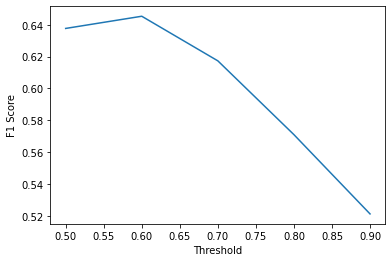

In [ ]:
scores=[]
threshold=np.arange(0.5, 1, 0.1)
for thresh in threshold:
  idxs=[]
  for i in range (sim.shape[0]):
    idxs.append(np.argwhere(sim[i]>=thresh).reshape(1, -1).tolist()[0])
  pst=[]
  for i in idxs:
    pst.append(dataset.posting_id.iloc[i].tolist())
  dataset['predictions']=pst
  f1=[]
  for i in range (len(dataset)):
      a=len(np.intersect1d(dataset.iloc[i].target, dataset.iloc[i].predictions))
      b=len(dataset.iloc[i].target) + len(dataset.iloc[i].predictions)
      f1.append(2*a/b)
  scores.append(np.mean(f1))
  
  clear_output (True)
  print(f"Currently F1 score at distance < {thresh}: {scores[-1]}")
  print (f"Max F1 score {max(scores)} at threshold < {threshold[scores.index(max(scores))]}")
  plt.plot (threshold[:len(scores)], scores)
  plt.xlabel("Threshold")
  plt.ylabel("F1 Score")
  plt.show()

In [ ]:
# scores=[]
# threshold=np.arange(0.4, 1.2, 0.1)
# for thresh in threshold:
#   idxs=[]
#   for i in range (text_indices.shape[0]):
#     idxs.append(text_indices[i][text_distances[i]<thresh].tolist())
#   pst=[]
#   for i in idxs:
#     pst.append(dataset.posting_id.iloc[i].tolist())
#   dataset['predictions']=pst
#   f1=[]
#   for i in range (len(dataset)):
#       a=len(np.intersect1d(dataset.iloc[i].target, dataset.iloc[i].predictions))
#       b=len(dataset.iloc[i].target) + len(dataset.iloc[i].predictions)
#       f1.append(2*a/b)
#   scores.append(np.mean(f1))
  
#   clear_output (True)
#   print(f"Currently F1 score at distance < {thresh}: {scores[-1]}")
#   print (f"Max F1 score {max(scores)} at threshold < {threshold[scores.index(max(scores))]}")
#   plt.plot (threshold[:len(scores)], scores)
#   plt.xlabel("Threshold")
#   plt.ylabel("F1 Score")
#   plt.show()

In [ ]:
for i in text_indices[0]:
  print (dataset.iloc[i]['title'])

PAPER BAG VICTORIA SECRET
Paper Bag Victoria Secret
READY! GRATIS ISI ULANG! Pengharum parfum mobil ruangan lemari tas victoria secret bombshell
PAPER BAG THE BODY SHOP
Paper Bag | Shopping Bag | Tas Kertas Polos Ukuran 18 x 5 x 22
Paper Bag The Body Shop Small
b"victoria iria Goat's Milk Hand Body Lotion 250ml"
Paper Bag Tas Kertas Polos Ukuran 18x5x22
VELROSE SECRET FACE MASK
Dengan Paper Bag TABITA EXCLUSIVE ORIGINAL KEMASAN KECIL
WARDAH WHITE SECRET FACIAL WASH 100ml
TABITA SKIN CARE ORIGINAL LENGKAP DENGAN PAPER BAG ( KECIL) -
MASKER WAJAH ORGANIK VELROSE SECRET
Wardah white secret pure brightening cleanser
Wardah White Secret Pure Brightening Cleanser
Paper Waxing / Hair Removal Strip / Paper Wax / Pencabut Bulu
Wardah White Secret Exfoliating Lotion 150 ml
Wardah White Secret Exfoliating Lotion 150 ml
Secret Clean Helmet Disinfectant 100ml
WARDAH WHITE SECRET PURE BRIGHTENING CLEANSER 150ML
TABITA SKIN CARE ORIGINAL SET (NON DS) LENGKAP DENGAN PAPER BAG
PAPER KLIP PENJEPIT KERTA

# Image Embedding

In [ ]:
BASE="./train_images/"

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, img_size=256, batch_size=32, path=BASE): 
        self.df = df
        self.img_size = img_size
        self.batch_size = batch_size
        self.path = path
        self.indexes = np.arange( len(self.df) )
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = len(self.df) // self.batch_size
        ct += int(( (len(self.df)) % self.batch_size)!=0)
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indexes)
        return X
            
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        X = np.zeros((len(indexes),self.img_size,self.img_size,3),dtype='float32')
        df = self.df.iloc[indexes]
        for i,(index,row) in enumerate(df.iterrows()):
            img = cv.imread(self.path+row.image)
            X[i,] = cv.resize(img,(self.img_size,self.img_size)) #/128.0 - 1.0
        return X

In [ ]:
model = EfficientNetB0(weights='imagenet',include_top=False, pooling='avg', input_shape=None)
train_gen = DataGenerator(dataset, batch_size=128)
image_embeddings = model.predict(train_gen,verbose=1)
print('image embeddings shape is',image_embeddings.shape)

268/268 [==============================] - 279s 1s/step
image embeddings shape is (34250, 1280)


In [ ]:
KNN=50
neighbors_model=NearestNeighbors(n_neighbors=KNN)
nbrs=neighbors_model.fit(image_embeddings)
img_distances, img_indices=nbrs.kneighbors(image_embeddings)

In [ ]:
idxs=[]
for i in range (img_indices.shape[0]):
  idxs.append(img_indices[i][img_distances[i]<7].tolist())
pst=[]
for i in idxs:
  pst.append(dataset.posting_id.iloc[i].tolist())
dataset['predictions']=pst

In [ ]:
# scores=[]
# threshold=np.arange(1, 12)
# for thresh in threshold:
#   idxs=[]
#   for i in range (img_indices.shape[0]):
#     idxs.append(img_indices[i][img_distances[i]<thresh].tolist())
#   pst=[]
#   for i in idxs:
#     pst.append(dataset.posting_id.iloc[i].tolist())
#   dataset['predictions']=pst
#   f1=[]
#   for i in range (len(dataset)):
#       a=len(np.intersect1d(dataset.iloc[i].target, dataset.iloc[i].predictions))
#       b=len(dataset.iloc[i].target) + len(dataset.iloc[i].predictions)
#       f1.append(2*a/b)
#   scores.append(np.mean(f1))
  
#   clear_output (True)
#   print(f"Currently F1 score at distance < {thresh}: {scores[-1]}")
#   print (f"Max F1 score {max(scores)} at threshold < {threshold[scores.index(max(scores))]}")
#   plt.plot (threshold[:len(scores)], scores)
#   plt.xlabel("Threshold")
#   plt.ylabel("F1 Score")
#   plt.show()

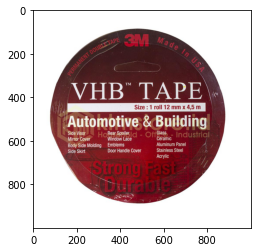

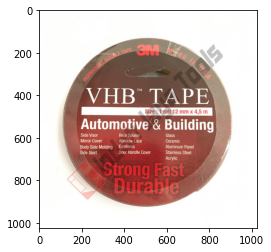

In [ ]:
for i in idxs[1]:
  img=plt.imread (BASE+dataset.iloc[i].image)
  plt.imshow(img)
  plt.show()

# Image Embedding 2

In [ ]:
model = EfficientNetB0(weights='efficientnetb0_notop.h5', include_top=False, pooling='avg', input_shape=None)
train_gen = DataGenerator(dataset, batch_size=128)
image_embeddings = model.predict(train_gen,verbose=1)
print('image embeddings shape is',image_embeddings.shape)

268/268 [==============================] - 274s 1s/step
image embeddings shape is (34250, 1280)


In [ ]:
KNN=50
neighbors_model=NearestNeighbors(n_neighbors=KNN)
nbrs=neighbors_model.fit(image_embeddings)
img_distances_2, img_indices_2=nbrs.kneighbors(image_embeddings)

In [ ]:
img_distances_2[1]

array([ 0.       ,  5.8442917,  7.500262 ,  7.5753994,  8.393452 ,
       10.459172 , 10.700116 , 10.99489  , 11.033879 , 11.0891285,
       11.170837 , 11.26122  , 11.357184 , 11.676769 , 11.6907425,
       11.713073 , 11.716344 , 11.774883 , 11.842573 , 11.853352 ,
       11.886421 , 11.907582 , 11.922708 , 12.150696 , 12.173734 ,
       12.1762905, 12.218568 , 12.27741  , 12.311471 , 12.322446 ,
       12.329954 , 12.339579 , 12.362771 , 12.389143 , 12.423629 ,
       12.423629 , 12.423629 , 12.423629 , 12.437028 , 12.4645195,
       12.482451 , 12.500342 , 12.538233 , 12.579144 , 12.598452 ,
       12.62552  , 12.681231 , 12.698728 , 12.698728 , 12.755719 ],
      dtype=float32)

Currently F1 score at distance < 14: 0.1807691940610401
Max F1 score 0.6467527679703687 at threshold < 7


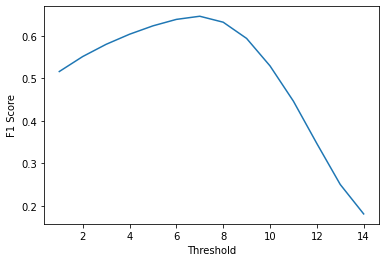

In [ ]:
scores=[]
threshold=np.arange(1, 15)
for thresh in threshold:
  idxs=[]
  for i in range (img_indices_2.shape[0]):
    idxs.append(img_indices_2[i][img_distances_2[i]<thresh].tolist())
  pst=[]
  for i in idxs:
    pst.append(dataset.posting_id.iloc[i].tolist())
  dataset['predictions']=pst
  f1=[]
  for i in range (len(dataset)):
      a=len(np.intersect1d(dataset.iloc[i].target, dataset.iloc[i].predictions))
      b=len(dataset.iloc[i].target) + len(dataset.iloc[i].predictions)
      f1.append(2*a/b)
  scores.append(np.mean(f1))
  
  clear_output (True)
  print(f"Currently F1 score at distance < {thresh}: {scores[-1]}")
  print (f"Max F1 score {max(scores)} at threshold < {threshold[scores.index(max(scores))]}")
  plt.plot (threshold[:len(scores)], scores)
  plt.xlabel("Threshold")
  plt.ylabel("F1 Score")
  plt.show()

# F1 Score

In [ ]:
tmp = dataset.groupby('label_group').posting_id.agg('unique').to_dict()
dataset['target'] = dataset.label_group.map(tmp)

In [ ]:
idxs=[]
for i in range (img_indices.shape[0]):
  idxs.append(img_indices[i][img_distances[i]<7].tolist())
pst=[]
for i in idxs:
  pst.append(dataset.posting_id.iloc[i].tolist())
dataset['img_predictions']=pst

In [ ]:
idxs=[]
for i in range (text_indices.shape[0]):
  idxs.append(text_indices[i][text_distances[i]<0.9].tolist())
pst=[]
for i in idxs:
  pst.append(dataset.posting_id.iloc[i].tolist())
dataset['text_predictions']=pst

In [ ]:
dataset['predictions']=0
for i in range (dataset.shape[0]):
  dataset.predictions.iloc[i]=dataset.img_predictions.iloc[i]+dataset.text_predictions.iloc[i]
  dataset.predictions.iloc[i]=np.unique(dataset.predictions.iloc[i])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
dataset.head()

,posting_id,image,image_phash,title,label_group,predictions,target,img_predictions,text_predictions
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]","[train_129225211, train_2278313361]",[train_129225211],"[train_2278313361, train_129225211]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_1974987067, train_211200223, train_3386...","[train_3386243561, train_3423213080]","[train_3386243561, train_3423213080]","[train_3386243561, train_3423213080, train_860..."
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]","[train_2288590299, train_3803689425]",[train_2288590299],"[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_1508100548, train_1744956981, train_204...","[train_2406599165, train_3342059966]",[train_2406599165],"[train_2406599165, train_1744956981, train_352..."
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]","[train_3369186413, train_921438619]","[train_3369186413, train_921438619]",[train_3369186413]


In [ ]:
f1=[]
for i in range (len(dataset)):
    a=len(np.intersect1d(dataset.iloc[i].target, dataset.iloc[i].predictions))
    b=len(dataset.iloc[i].target) + len(dataset.iloc[i].predictions)
    f1.append(2*a/b)
print ("F1 Score: ", np.mean(f1))

F1 Score:  0.7207172289806757
